In [192]:
import torch
import pandas as pd
import numpy as np
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device for torch operations:", device)

# Fonction autovel adaptée à notre structure avec identifiants uniques
# def autovel(dX, n, tau, noise, dt, persistence):
#     dX_norm = dX / (torch.norm(dX) + 1e-8)  # Éviter la division par zéro
#     theta_initial = torch.atan2(n[1], n[0])
#     # Appliquer le bruit pour simuler le changement de direction
#     theta_noise = noise * (2 * np.pi * (torch.rand(1) - 0.5)) * np.sqrt(dt)
    
#     dtheta = torch.arcsin((n[0] * dX_norm[1] - n[1] * dX_norm[0])) * dt / tau # * (1 - persistence))
#     theta_new = theta_initial + theta_noise + dtheta
    
#     # Calculer la nouvelle direction
#     n_new = torch.tensor([torch.cos(theta_new), torch.sin(theta_new)])
    
#     return n_new, theta_noise, theta_initial, theta_new
def autovel(dX, n, tau, noise, dt, persistence):
    """
    Calcule la nouvelle direction des cellules basée sur leur déplacement,
    leur direction précédente, le bruit, le temps caractéristique tau, et la persistance.
    
    Paramètres
    ----------
    dX : Tensor
        Le déplacement des cellules durant le dernier intervalle de temps.
    n : Tensor
        La direction actuelle des cellules.
    tau : float
        Le temps caractéristique pour l'alignement de la polarisation dans
        la direction définie par la vitesse = dX/dt.
    noise : float
        L'intensité du bruit ajouté pour simuler des perturbations aléatoires
        dans la direction des cellules.
    dt : float
        L'intervalle de temps entre les mises à jour des positions.
    persistence : float
        Le facteur de persistance qui influence à quel point la direction actuelle
        est conservée. Valeur entre 0 (pas de persistance, direction entièrement aléatoire)
        et 1 (persistance complète, pas de changement de direction).

    Retour
    -------
    n : Tensor
        La nouvelle direction des cellules après mise à jour.
    """    
    # Compute the angle between the input vector and the x-axis
    theta = torch.atan2(dX[1], dX[0]).to(device)
    print(dX)
    # Normalize the input vector
    dX_norm = torch.nn.functional.normalize(dX) * 0.9999999
    if persistence == 1:
        persistence = 0.9999999

    # Compute the change in angle based on the orientation vector (n)
    dtheta = 0 * torch.arcsin((n[0] * dX_norm[1] - n[1] * dX_norm[0])) * dt / tau # * (1 - persistence))

    # Generate random noise for angle perturbation
    # rnd = noise * (2 * math.pi * (torch.rand(len(dX), 1, device=device) - 0.5)) * np.sqrt(dt) * (1 - persistence)
    rnd = noise * (2 * math.pi * (torch.rand(1) - 0.5)) * np.sqrt(dt) #* (1 - persistence)
    
    # Capture de theta avant sa mise à jour
    initial_theta = theta.clone()  # Utilisez clone() pour éviter les modifications inattendues
    # Update the angle by adding the change in angle, random noise, and the previous angle
    theta_update = initial_theta + dtheta + rnd.squeeze(1)

    # Calculate the weighted average of the new direction and the old direction
    new_dir_x = torch.cos(theta_update) #* (1 - persistence) + n[:, 0] * persistence
    new_dir_y = torch.sin(theta_update) #* (1 - persistence) + n[:, 1] * persistence
    
    # Créer un nouveau tenseur pour la direction mise à jour au lieu de modifier n
    new_direction = torch.stack((new_dir_x, new_dir_y), dim=1)
    
    # Fonction pour calculer l'angle en degrés entre deux vecteurs de direction successifs
    def angle_between_directions(n, n_new):
        # Extract direction components
        dx1, dy1 = n[0], n[1]
        dx2, dy2 = n_new[0], n_new[1]
        
        # Calculate initial and final angles using arctan2 for each direction vector
        angle_initial = np.arctan2(dy1, dx1)
        angle_final = np.arctan2(dy2, dx2)
        
        # Calculate the angle difference
        angle_change = angle_final - angle_initial
        
        return angle_change
    
    angle_entre_vecteur = angle_between_directions(n, new_direction)
    if angle_entre_vecteur > np.pi:
        angle_entre_vecteur = angle_entre_vecteur - 2 * np.pi
    if angle_entre_vecteur < -np.pi:
        angle_entre_vecteur = angle_entre_vecteur + 2 * np.pi
    # Retourne la nouvelle direction, rnd, dtheta, et initial_theta
    return new_direction, rnd, dtheta, initial_theta, angle_entre_vecteur

# Classes CellAgent et Population
class CellAgent:
    def __init__(self, pop_id, cell_id, position, velocity, velocity_magnitude, persistence, space_size):
        self.id = (pop_id, cell_id)
        self.position = position
        self.velocity = velocity
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.space_size = space_size
        self.direction = torch.nn.functional.normalize(velocity, p=2, dim=0)

class Population:
    def __init__(self, pop_id, num_cells, space_size, velocity_magnitude, persistence, min_distance):
        self.pop_id = pop_id
        self.num_cells = num_cells
        self.space_size = space_size
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.min_distance = min_distance
        self.cells = []  # Liste pour maintenir une référence facile aux objets CellAgent
        self.cells_dict = {}  # Dictionnaire pour un accès rapide aux CellAgent par leur id
        self.initialize_cells()

    def initialize_cells(self):
        grid_size = int(np.ceil(self.space_size / self.min_distance))
        grid = [[[] for _ in range(grid_size)] for _ in range(grid_size)]
        attempts, max_attempts = 0, self.num_cells * 10

        for i in range(self.num_cells):
            valid = False
            while not valid and attempts < max_attempts:
                position = torch.rand(2, device=device) * self.space_size
                velocity = torch.randn(2, device=device) * self.velocity_magnitude
                direction = torch.nn.functional.normalize(velocity, p=2, dim=0)

                grid_x, grid_y = int(position[0] / self.min_distance), int(position[1] / self.min_distance)
                valid = True
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        nx, ny = grid_x + dx, grid_y + dy
                        if 0 <= nx < grid_size and 0 <= ny < grid_size:
                            for other_position in grid[nx][ny]:
                                if torch.norm(position - other_position) < self.min_distance:
                                    valid = False
                                    break
                            if not valid: break
                    if not valid: break

                if valid:
                    grid[grid_x][grid_y].append(position)
                    cell = CellAgent(self.pop_id, i, position, velocity, self.velocity_magnitude, self.persistence, self.space_size)
                    self.cells.append(cell)
                    self.cells_dict[(self.pop_id, i)] = cell
                attempts += 1

        if attempts >= max_attempts:
            print(f"Warning: Reached max attempts ({max_attempts}) while placing cells.")


Device for torch operations: cpu


In [193]:

# Initialisation des paramètres de simulation et des populations
# In[Simulation parameters]
# Space parameters
SPACE_SIZE = 2048 #1308 # Micrometers

# time settings
TIME_SIMU = 10 # time simulation in minutes
DELTA_T = 0.01 # 15/60 # 0.01 # simulation interval in minutes
PLOT_INTERVAL = 100 # 25

# simulation parameters
MU = 0 #1  # mobility in min.kg-1
R_EQ = 1.1
MIN_DISTANCE_INIT = R_EQ

# factor simulation
NOISE = 5 #10 # noise intensity
FLUCTUATION_FACTOR = 0 #4
TAU = 5 # 5 # characteristic time for the polarization to align in the scattering direction defined by v=dr/dt = time
PERSISTENCE_POP1 = 0 #0.1
PERSISTENCE_POP2 = 0 #0.4

# Cells definition
PACKING_FRACTION = 0.00002
N_CELLS = int((PACKING_FRACTION*SPACE_SIZE**2)/
              (math.pi*((R_EQ/2)**2)))  # number of particles
print(N_CELLS, "cells")
velocity_magnitude_pop1 = 5 #um/min
velocity_magnitude_pop2 = 5 # um/min

# In[Definition of the populations]
population1 = Population(pop_id = 1, num_cells=int(N_CELLS/2), space_size=SPACE_SIZE,\
                         velocity_magnitude=velocity_magnitude_pop1,\
                         persistence=PERSISTENCE_POP1,\
                         min_distance=MIN_DISTANCE_INIT)

population2 = Population(pop_id = 2, num_cells=int(N_CELLS/2), space_size=SPACE_SIZE,\
                         velocity_magnitude=velocity_magnitude_pop2,\
                         persistence=PERSISTENCE_POP2,\
                         min_distance=MIN_DISTANCE_INIT)
# population1 = Population(pop_id = 1, N_CELLS, SPACE_SIZE, 5, PERSISTENCE_POP1, 1.1)
# population2 = Population(2, N_CELLS, SPACE_SIZE, 5, PERSISTENCE_POP2, 1.1)

# DataFrame pour l'enregistrement
columns = ['time', 'pop_id', 'cell_id', 'x', 'y', 'dir_x', 'dir_y', 'theta_noise', 'theta_initial', 'theta_new']
data_frame = pd.DataFrame(columns=columns)

# Boucle de simulation avec une liste de dictionnaires pour l'enregistrement des données
records = []

time = 0
while time < TIME_SIMU:
    for pop in [population1, population2]:
        for cell_id, cell in pop.cells_dict.items():
            displacement = cell.velocity_magnitude * DELTA_T * cell.direction
            cell.position += displacement
            cell.position = torch.remainder(cell.position, SPACE_SIZE)
            
            # n_new, theta_noise, theta_initial, theta_new = autovel(displacement, cell.direction, TAU, NOISE, DELTA_T, cell.persistence)
            n_new, rnd, theta_noise, theta_initial, theta_new = autovel(displacement, cell.direction, TAU, NOISE, DELTA_T, persistence=cell.persistence)
            cell.direction = n_new
            # Ajout d'un enregistrement pour chaque cellule à la liste
            records.append({
                'frame': time, 'pop_id': cell.id[0], 'particle': cell.id[1],
                'x': cell.position[0].item(), 'y': cell.position[1].item(),
                'dir_x': cell.direction[0].item(), 'dir_y': cell.direction[1].item(),
                'theta_noise': theta_noise.item(), 'theta_initial': theta_initial.item(), 'theta_new': theta_new.item()
            })
            
    time += DELTA_T

# Convertir la liste de dictionnaires en DataFrame après la boucle
data_frame = pd.DataFrame(records)

# Vous pouvez maintenant analyser data_frame pour observer la dynamique de vos cellules


88 cells
tensor([-0.0084,  0.0493])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
cell.velocity

tensor([0.3390, 5.9994])

In [ ]:
0.5114**2 + 0.8593**2

0.9999264499999999

In [ ]:
dX_norm = displacement / (torch.norm(displacement) +1e-8)

In [ ]:
dX_norm[1]

tensor(0.9897)

In [ ]:
data_frame.sort_values(by=['particle', 'frame'], inplace=True)

In [ ]:
df = data_frame[(data_frame['particle'] == 2) & (data_frame['pop_id'] == 1)]
df['x_next'] = df['x'].shift(-1)
df['y_next'] = df['y'].shift(-1)
df['dx'] = df['x_next'] - df['x']
df['dy'] = df['y_next'] - df['y']

import numpy as np

# Calcul de la norme du vecteur pour chaque ligne
df['norm'] = np.sqrt(df['dx']**2 + df['dy']**2)

# Normalisation des composantes dx et dy
df['dx_norm'] = df['dx'] / df['norm']
df['dy_norm'] = df['dy'] / df['norm']



df[['frame', 'dir_x', 'dir_y', 'dx_norm', 'dy_norm']]

/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_47570/2722938780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_next'] = df['x'].shift(-1)
/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_47570/2722938780.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y_next'] = df['y'].shift(-1)
/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_47570/2722938780.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,frame,dir_x,dir_y,dx_norm,dy_norm
2,0.00,-0.901027,-0.433763,-0.900683,-0.434476
90,0.01,-0.385881,-0.922548,-0.385655,-0.922643
178,0.02,0.847366,-0.531010,0.846762,-0.531972
266,0.03,-0.396084,-0.918214,-0.395687,-0.918385
354,0.04,0.597133,-0.802142,0.596481,-0.802627
...,...,...,...,...,...
87650,9.96,0.379609,-0.925147,0.379583,-0.925158
87738,9.97,0.171802,-0.985131,0.171907,-0.985113
87826,9.98,0.254680,-0.967025,0.255154,-0.966900
87914,9.99,-0.244230,-0.969717,-0.244259,-0.969710


In [ ]:
df

,frame,pop_id,particle,x,y,dir_x,dir_y,theta_noise,theta_initial,theta_new,x_next,y_next,dx,dy,norm,dx_norm,dy_norm
2,0.00,1,2,737.735413,1763.723999,-0.901027,-0.433763,1.213828,2.376429,3.590258,737.690369,1763.702271,-0.045044,-0.021729,0.050011,-0.900683,-0.434476
90,0.01,1,2,737.690369,1763.702271,-0.385881,-0.922548,0.725968,-2.692928,-1.966959,737.671082,1763.656128,-0.019287,-0.046143,0.050011,-0.385655,-0.922643
178,0.02,1,2,737.671082,1763.656128,0.847366,-0.531010,1.407168,-1.966959,-0.559792,737.713440,1763.629517,0.042358,-0.026611,0.050024,0.846762,-0.531972
266,0.03,1,2,737.713440,1763.629517,-0.396084,-0.918214,-1.418253,-0.559792,-1.978045,737.693665,1763.583618,-0.019775,-0.045898,0.049977,-0.395687,-0.918385
354,0.04,1,2,737.693665,1763.583618,0.597133,-0.802142,1.047171,-1.978045,-0.930874,737.723511,1763.543457,0.029846,-0.040161,0.050037,0.596481,-0.802627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87650,9.96,1,2,739.045593,1761.725830,0.379609,-0.925147,1.343833,-2.525256,-1.181423,739.064575,1761.679565,0.018982,-0.046265,0.050007,0.379583,-0.925158
87738,9.97,1,2,739.064575,1761.679565,0.171802,-0.985131,-0.216714,-1.181423,-1.398137,739.073181,1761.630249,0.008606,-0.049316,0.050062,0.171907,-0.985113
87826,9.98,1,2,739.073181,1761.630249,0.254680,-0.967025,0.084858,-1.398137,-1.313279,739.085938,1761.581909,0.012756,-0.048340,0.049995,0.255154,-0.966900
87914,9.99,1,2,739.085938,1761.581909,-0.244230,-0.969717,-0.504243,-1.313279,-1.817522,739.073730,1761.533447,-0.012207,-0.048462,0.049976,-0.244259,-0.969710


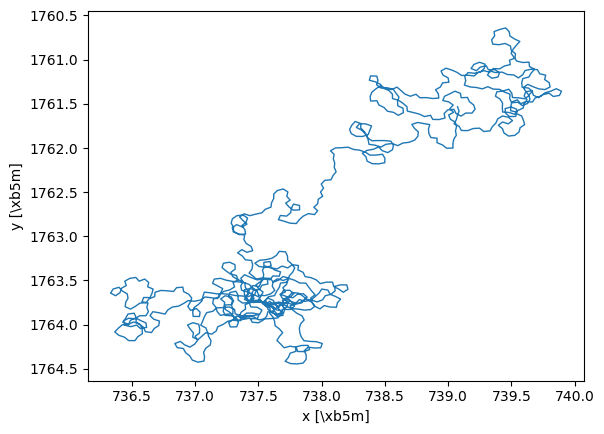

<Axes: xlabel='x [\\xb5m]', ylabel='y [\\xb5m]'>

In [ ]:
import trackpy as tp 

tp.plot_traj(df, mpp=1)